In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [25]:
data = pd.read_csv("./input/train.csv")

Label: 1


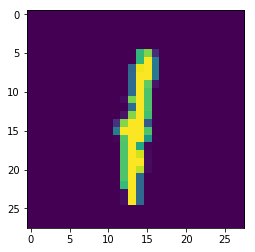

In [8]:
def plot_img(i, X=X, Y=Y):
    print("Label: {}".format(Y[i]))
    plt.close()
    plt.figure()
    plt.imshow(X[i,:,:])
    plt.show()

plot_img(12)

In [55]:
m = len(data)
X = np.array(data.loc[:, data.columns != 'label'])
X = X.reshape(m, 28, 28)
Y = np.array(data['label'])

In [56]:
print("Shape of X: {}, shape of Y: {}".format(X.shape, Y.shape))

Shape of X: (42000, 28, 28), shape of Y: (42000,)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [58]:
print("Shape of X_train: {}, shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {}, shape of y_test: {}".format(X_test.shape, y_test.shape))

Shape of X_train: (31500, 28, 28), shape of y_train: (31500,)
Shape of X_test: (10500, 28, 28), shape of y_test: (10500,)


In [9]:
y_train_onehot = tf.one_hot(indices=tf.cast(y_train, tf.int32), depth=10)
y_test_onehot = tf.one_hot(indices=tf.cast(y_test, tf.int32), depth=10)

In [10]:
print("Onehot representation: Shape of y_train: {}, shape of y_test: {}".format(y_train_onehot, y_test_onehot))

Onehot representation: Shape of y_train: Tensor("one_hot:0", shape=(31500, 10), dtype=float32), shape of y_test: Tensor("one_hot_1:0", shape=(10500, 10), dtype=float32)


In [136]:
def cnn_model(features, labels, mode):
    #input layer
    input_layer = tf.reshape(features['x'], [-1, 28, 28, 1])
    
    #conv layer 1
    conv1 = tf.layers.conv2d(inputs=input_layer, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    
    #pooling layer 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    #conv layer 2
    conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    
    #pooling layer 2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    #flatten the pooling output to feed in dense layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    
    #dense layer
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    
    #dropoout layer
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    #logits layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    #create dictionary with predicted classes and their probabilities
    predictions = {"classes": tf.argmax(input=logits, axis=1), "probabilities": tf.nn.softmax(logits, name="softmax_tensor")}
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    #calculate loss
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [34]:
def loaddata():
    # Load training and eval data
    mnist = tf.contrib.learn.datasets.load_dataset("mnist")
    train_data = mnist.train.images # Returns np.array
    train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
    eval_data = mnist.test.images # Returns np.array
    eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
    return train_data, train_labels

In [35]:
train_data, train_labels = loaddata()

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [81]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print(type(train_data[0,0]), type(X_train[0,0,0]))
print(type(X_test[0,0,0]))
print(type(train_labels[0]), type(y_train[0]))

<class 'numpy.float32'> <class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.int32'> <class 'numpy.int64'>


In [137]:
def main(unused_argv):
    # Create the Estimator
    mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model, model_dir="./tmp/mnist_convnet_model")
    
    # Set up logging for predictions
    #tensors_to_log = {"probabilities": "softmax_tensor"}
    #logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
    
    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_train}, y=y_train, batch_size=100, num_epochs=None, shuffle=True)
    mnist_classifier.train(input_fn=train_input_fn, steps=1000)#, hooks=[logging_hook])
    
    return mnist_classifier

In [138]:
mnist_classifier = main(None)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_model_dir': './tmp/mnist_convnet_model', '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_session_config': None, '_tf_random_seed': 1, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./tmp/mnist_convnet_model\model.ckpt.
INFO:tensorflow:loss = 42.63, step = 1
INFO:tensorflow:global_step/sec: 2.28291
INFO:tensorflow:loss = 0.563537, step = 101 (43.804 sec)
INFO:tensorflow:global_step/sec: 1.75898
INFO:tensorflow:loss = 0.359202, step = 201 (56.851 sec)
INFO:tensorflow:global_step/sec: 1.66483
INFO:tensorflow:loss = 0.31632, step = 301 (60.082 sec)
INFO:tensorflow:global_step/sec: 1.89846
INFO:tensorflow:loss = 0.401407, step = 401 (52.659 sec)
INFO:tensorflow:global_step/sec: 2.00293
INFO:tensorflow:loss = 0.186543, step = 501 (49.927 

In [110]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test}, num_epochs=1, shuffle=False)
p = list(mnist_classifier.predict(input_fn=test_input_fn))

INFO:tensorflow:Restoring parameters from ./tmp/mnist_convnet_model\model.ckpt-20


In [113]:
pred = [i['classes'] for i in p]

In [116]:
print(pred[:10])
print(y_test[:10])

[5, 6, 7, 5, 6, 4, 6, 0, 0, 1]
[3 6 9 5 6 5 6 0 0 1]
